# Ensemble Learning

when you ask for the answer of random people then ou found the answer is better than an expert's answer. This is called *wisdom of the crowd*, a group of predictor is called an *ensemble*.

you can train a group of DecisionTree Classifiers, on different random subset of the training set, To predict idividual trees, then get most votes. This called **RamdomForest**

we will discuss the most popular Ensemblie methods :
* bagging
* boosting

## Voting Classifiers
have a few classifiers then use majority-vote to predict class, This is called an *hard voing classifer*.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [43]:
X, y = make_moons(500, noise=.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Log_model = LogisticRegression(solver='lbfgs', random_state=42)
Rdf_model = RandomForestClassifier(n_estimators=100, random_state=42)
Svm_model = SVC(gamma='scale', random_state=42)

Voting_clf = VotingClassifier(
    estimators=[('Lr',Log_model),('Rf',Rdf_model),('Svm',Svm_model)],
    voting='hard' # or 'soft'
)

Voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('Lr', LogisticRegression(random_state=42)),
                             ('Rf', RandomForestClassifier(random_state=42)),
                             ('Svm', SVC(random_state=42))])

In [44]:
from sklearn.metrics import accuracy_score

for model in (Log_model, Rdf_model, Svm_model, Voting_clf):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{model.__class__.__name__} = {accuracy_score(y_test, y_pred)}')

LogisticRegression = 0.864
RandomForestClassifier = 0.896
SVC = 0.896
VotingClassifier = 0.912


> There you have it! The voting classifier slightly outperforms all the individual classifiers

if want to using 'soft' for voting
* expressed in terms of probabilities then take average or them and predict by threshold(defualt=.5)
* change model parameter 'probability=True'

## Bagging and Pasting

using the same algorithm but train on different random subsets,
* bagging is performed with replacement(bootstrap)
* pasting don't


In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

Bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, # number of model(DecisionTree)
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=41
    # 100 instance randomly train from boostrap(True),
    #  n_jobs = -1 mean use all CPU core availabel
)

Bag_clf.fit(X_train, y_train)
y_pred = Bag_clf.predict(X_test)

In [46]:
print('accuracy = ',accuracy_score(y_test, y_pred))

accuracy =  0.92


> BaggingClassifier automatically performs soft voting instead of hard voting can use predict_proba() 

In [47]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
print('accuracy = ',accuracy_score(y_test, y_pred_tree))

accuracy =  0.856


In [48]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

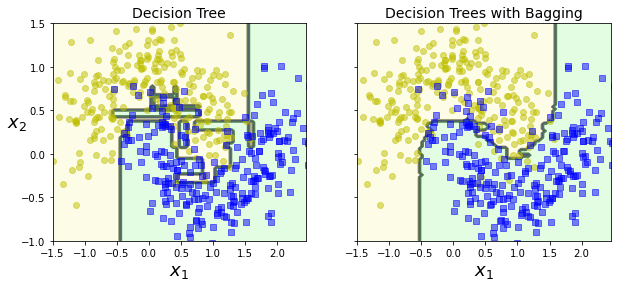

In [49]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_model, X, y)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(Bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

## Out-of-Bag 

in Sklearn, By default a *BaggingClassifier* random sampling 63% of instance this mean 37% is remaining, This is called *out of the bag (oob)*, can evaluate average accuracy from all of traning instance.

In [50]:
Bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=42
)

Bag_clf.fit(X_train, y_train)
Bag_clf.oob_score_

0.896

> According to this oob evaluation, this BaggingClassifier is likely to achieve about 89.6 % on test set

oob_decision_function_ is a predict_proba() of oob

In [51]:
Bag_clf.oob_decision_function_[:10] 

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97927461, 0.02072539]])

In [52]:
y_pred = Bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

> test set accuracy is greather than oob score!!

### Random Patches and Random Subspaces

This technique is particularly useful when you are dealing with high-dimensional inputs (such as images)
* *Random Patches* :method when sampling both training instances and features; bootstrap = False, max_samples = 1.0
* *Random Subspaces* method when keeping all training instances but sampling features; bootstrap_features = True and/or max_features to a value smaller than 1.0

see the [image](https://machinelearningjourney.com/index.php/2020/03/24/random-patches-and-random-subspaces/)

## Random Forest
is an ensemble of Decision Trees, each Tree have worth vote equality
* max_sample : set to size trainning set (number of given to any individual tree)
* max_leaf_nodes : each maximum node for individual tree

In [53]:
from sklearn.ensemble import RandomForestClassifier

Rdf_model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
Rdf_model.fit(X_train, y_train)

y_pred_rf = Rdf_model.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.912

A Random Forest is **equivalent** to a bagging of decision trees:

In [54]:
Bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16)
    , n_estimators=500 , random_state=42 ,bootstrap=True)
Bag_clf.fit(X_train, y_train)
y_pred = Bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

>  Max features is "Number of features allowed to make the best split while building the tree"

### Extra-Trees
**Exremely Randomized Trees**:more than random by using random threshold for each feature, is faster thean regular *Ramdom Forests* because finding the best possible threshold for every node: but performance depent on the data, in Scikitlearn can using **ExtraTreesClassifier**

### Feature Importance
measures a feature’s importance  by looking at how much the tree nodes that use that
feature reduce impurity on average 

In [55]:
from sklearn.datasets import load_iris

iris = load_iris()
Rdf_model = RandomForestClassifier(n_estimators=500, n_jobs=-1,random_state=42)
Rdf_model.fit(iris.data, iris.target)
for name, score in zip(iris.feature_names, Rdf_model.feature_importances_):
    print(name, score.round(4))

sepal length (cm) 0.1125
sepal width (cm) 0.0231
petal length (cm) 0.441
petal width (cm) 0.4234


> It seems that the most important
features are the petal length (44%) and width (42%), while sepal length
and width are rather unimportant in comparison (11% and 2%,
respectively):

MNIST pixel importance (according to a Random Forest classifier)

In [56]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False) # as numpy array
mnist['target'] = mnist['target'].astype(np.int8)

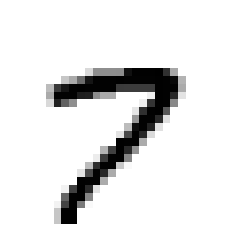

In [57]:
plt.imshow(mnist.data[123].reshape(28,28),cmap='binary')
plt.axis('off');

In [58]:
Rdf_model = RandomForestClassifier(n_estimators=100, random_state=42)
Rdf_model.fit(mnist.data, mnist.target)

RandomForestClassifier(random_state=42)

In [59]:
def plot_digit(array):
    image = array.reshape(28,28)
    plt.imshow(image, cmap = plt.cm.hot, interpolation='nearest')
    plt.axis('off')

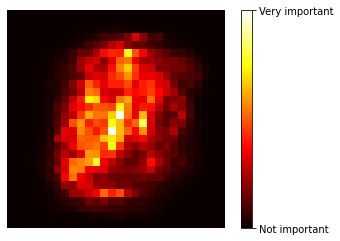

In [60]:
plot_digit(Rdf_model.feature_importances_)
cbar = plt.colorbar(ticks=[Rdf_model.feature_importances_.min(), Rdf_model.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

## Boosting
**hypothesis boosting**: any Ensemble
method that can combine several weak learners into a strong learner. " methods is to train predictors sequentially, each trying to correct its predecessor "

### AdaBoost
*forest of stumps*: each tree only have 1 node and 2 leaf(i.e. yes or no) that's weak learner. 
* each Trees(stumps) does not has equality vote.
* chain effect : the error for 1st make influence to the others and so on.
* * *SAMME* : uses the classifications only.
* * *SAMME.R* :  uses the probability estimates to update the additive model. 

In [101]:
from sklearn.ensemble import AdaBoostClassifier

Ada_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=1000,
    algorithm='SAMME.R', learning_rate=.1, random_state=41
)
Ada_model.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.1, n_estimators=1000, random_state=41)

In [102]:
pred = Ada_model.predict(X_test)
accuracy_score(y_test, pred)

0.912

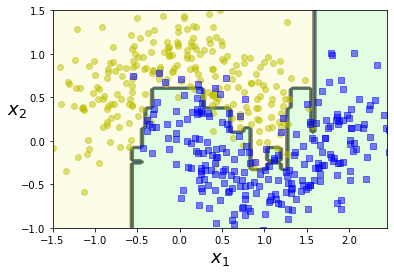

In [85]:
plot_decision_boundary(Ada_model,X,y)

### Gradient Boosting
adding predictors to an ensemble, each one correcting its predecessor. this method tries to fit the new predictor to the *residual errors* made by the previous predictor. This is called Gradient Tree Boosting, or Gradient Boosted
Regression Trees (GBRT)

n_estimators mean the number in range of DecisionTree; if n = 40 , n=1 (DecisionTree = 1), --> n=40 (DecisionTree = 40) 

Let create a simple quadratic dataset:

In [104]:
np.random.seed(32)
X = np.random.rand(100,1) - .5 # [0,1) shape (100,1)
y = 3*X[:,0]**2 + .05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor
Tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
Tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [105]:
y2 = y - Tree_reg1.predict(X)
Tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
Tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [106]:
y3 = y2 - Tree_reg2.predict(X)
Tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
Tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions
on a new instance simply by adding up the predictions of all the trees:

In [107]:
X_new = np.array([[.8]])
y_pred = sum(tree.predict(X_new) for tree in (Tree_reg1, Tree_reg2, Tree_reg3))
y_pred

array([0.60293418])

can make with **GradientBoostingRegressor** in easier way, will perform as the same if learning_rate = 1

In [108]:
from sklearn.ensemble import GradientBoostingRegressor

Gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,learning_rate=1, random_state=42 )
Gbrt.fit(X,y)
Gbrt.predict(X_new)

array([0.60293418])

In [109]:
Gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.09,random_state=42)
Gbrt_slow.fit(X, y)
Gbrt_slow.predict(X_new)

array([0.73973841])

In [110]:
def plot_prediction(models, X,y, axes, label=None, style='r-', data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(model.predict(x1.reshape(-1, 1)) for model in models)
    plt.plot(X[:,0], y, data_style, label=data_label)
    plt.plot(x1 , y_pred, style, label=label, linewidth=2)
    if label or data_label :
          plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

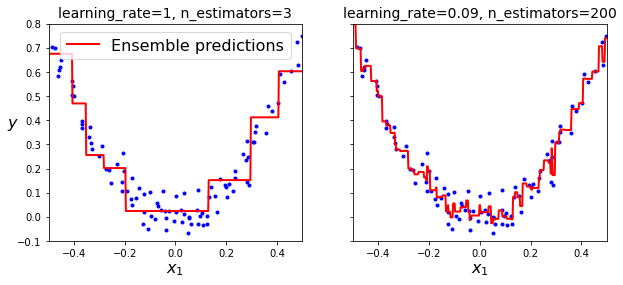

In [111]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0]) # set current axes
plot_prediction([Gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(Gbrt.learning_rate, Gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_prediction([Gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(Gbrt_slow.learning_rate, Gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

Gradient Boosting with Early stopping:

In [112]:
from sklearn.metrics import mean_absolute_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

Gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=43)
Gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=43)

In [113]:
errors = [ mean_absolute_error(y_val, y_pred) for y_pred in Gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1 # because it start from zero
bst_n_estimators

40

In [114]:
Gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
Gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=40, random_state=42)

In [115]:
min_error = np.min(errors)
min_error

0.059696175229978714

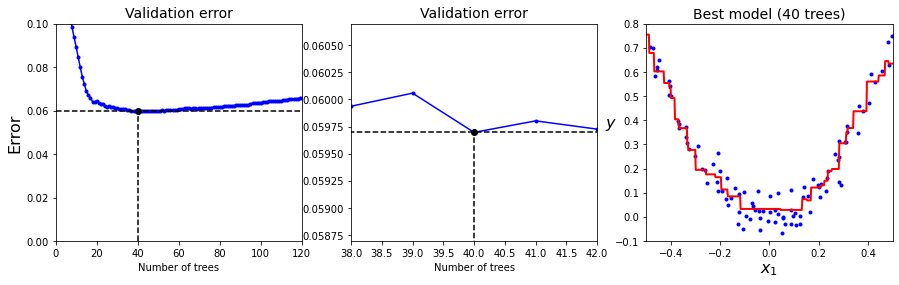

In [116]:
plt.figure(figsize=(15, 4))

plt.subplot(131) # row column channel
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.axis([0,120, 0, .1])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(132)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.axis([bst_n_estimators-2,bst_n_estimators+2, min_error-.001, min_error+.001])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(133)
plot_prediction([Gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number).

In [117]:
Gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=10)

min_val_error = float('inf') # very large number
error_going_up = 0
for n_estimators in range(1,121):
    Gbrt.n_estimators = n_estimators
    Gbrt.fit(X_train, y_train)
    y_pred = Gbrt.predict(X_val)
    val_error = mean_absolute_error(y_val, y_pred)
    if val_error < min_val_error :
        min_val_error = val_error
        error_going_up = 0
    else : # if loss not going down
        error_going_up += 1
        if error_going_up == 5 : 
            break # early stopping

print(f'n_estimators : {Gbrt.n_estimators}\nmin_val_error(mae) : {min_val_error:.6f}')

n_estimators : 45
min_val_error(mae) : 0.059696
